# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

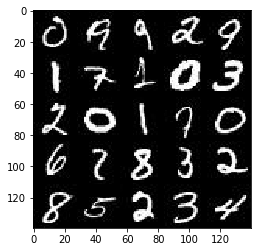

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

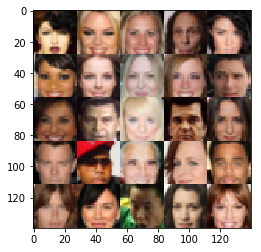

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images     = tf.placeholder(tf.float32, [None] + [image_width, image_height, image_channels], name='images')
    embeddings = tf.placeholder(tf.float32, [None] + [z_dim], name='embeddings')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')

    return images, embeddings, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
import tensorflow.contrib.slim as slim

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xDIM
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    images, embeddings, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(images, embeddings, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images: batch_images, embeddings: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={embeddings: batch_z, images: batch_images, learn_rate: learning_rate})

                # Run g optim twice
                _ = sess.run(g_train_opt, feed_dict={embeddings: batch_z, images: batch_images, learn_rate: learning_rate})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({embeddings: batch_z, images: batch_images})
                    train_loss_g = g_loss.eval({embeddings: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, embeddings, data_shape[3], data_image_mode)
                    
                steps += 1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.9131... Generator Loss: 0.0013


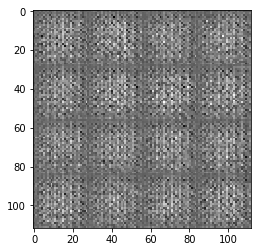

Epoch 1/2... Discriminator Loss: 4.3357... Generator Loss: 0.0590
Epoch 1/2... Discriminator Loss: 2.2230... Generator Loss: 0.4402
Epoch 1/2... Discriminator Loss: 2.5797... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 2.0847... Generator Loss: 0.3250
Epoch 1/2... Discriminator Loss: 1.6582... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 1.1020
Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 2.3399... Generator Loss: 0.1268
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.9202


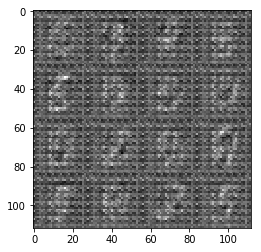

Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.3860
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.4512


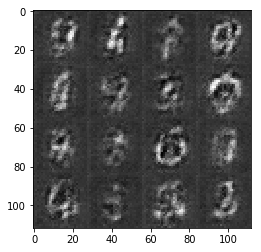

Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 1.9156
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 1.0047
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 0.6822


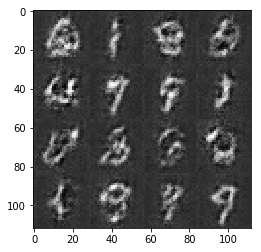

Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.4932
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 1.6828
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.4253
Epoch 1/2... Discriminator Loss: 1.7764... Generator Loss: 0.2123
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.3568
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.9949


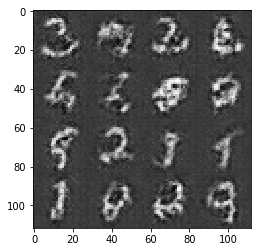

Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 0.5519... Generator Loss: 2.3507
Epoch 1/2... Discriminator Loss: 0.6596... Generator Loss: 1.0823
Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 1.4719
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.3096
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.7760... Generator Loss: 0.2132
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.5033
Epoch 2/2... Discriminator Loss: 0.6220... Generator Loss: 1.4286


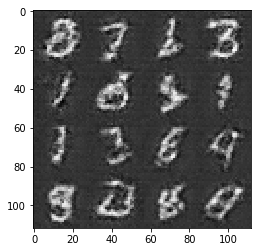

Epoch 2/2... Discriminator Loss: 0.5946... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 0.5144... Generator Loss: 2.2407
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.3758
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 3.3690... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 0.5612... Generator Loss: 1.2889
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 0.6821


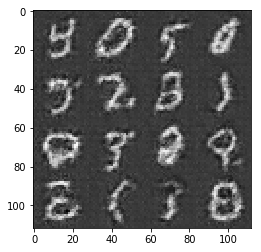

Epoch 2/2... Discriminator Loss: 0.2550... Generator Loss: 2.7840
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 0.2022... Generator Loss: 2.4419
Epoch 2/2... Discriminator Loss: 0.2233... Generator Loss: 3.3369
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 2.6136
Epoch 2/2... Discriminator Loss: 0.5477... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 1.3594
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 0.9792
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.5687


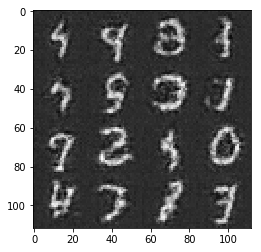

Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 2.8578
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 0.1348... Generator Loss: 3.2023
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 0.3929... Generator Loss: 1.5994
Epoch 2/2... Discriminator Loss: 0.4803... Generator Loss: 1.1796
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.1317... Generator Loss: 0.5432
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.0015


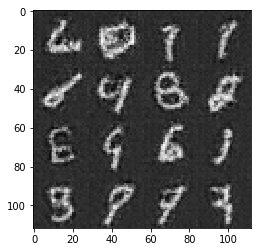

Epoch 2/2... Discriminator Loss: 0.3389... Generator Loss: 2.8672
Epoch 2/2... Discriminator Loss: 0.6013... Generator Loss: 2.7553
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.1308
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.4714
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.0076
Epoch 2/2... Discriminator Loss: 0.1885... Generator Loss: 2.9589
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 0.5615


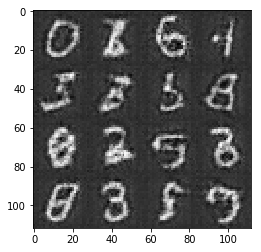

Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.7778
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 0.2796... Generator Loss: 2.4175


In [17]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 10.8118... Generator Loss: 0.0000


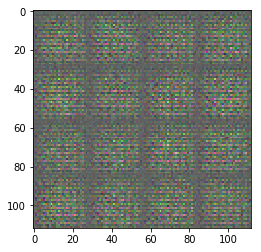

Epoch 1/1... Discriminator Loss: 5.2461... Generator Loss: 0.0159
Epoch 1/1... Discriminator Loss: 3.6318... Generator Loss: 0.0790
Epoch 1/1... Discriminator Loss: 4.5817... Generator Loss: 0.0398
Epoch 1/1... Discriminator Loss: 2.4547... Generator Loss: 0.2855
Epoch 1/1... Discriminator Loss: 2.0343... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 2.1844... Generator Loss: 0.2564
Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.6665... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 2.1991... Generator Loss: 0.2341


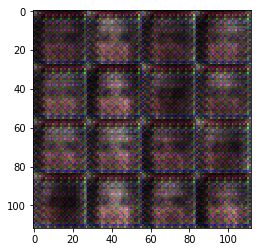

Epoch 1/1... Discriminator Loss: 1.9165... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 1.7086... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 2.1413... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.6899... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 2.2442... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.7250... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.6637... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.7479... Generator Loss: 0.4828


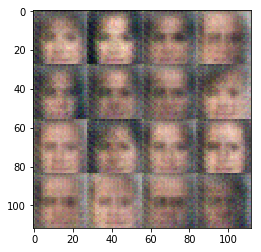

Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.9294... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.6883... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.7423... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.7045... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.5012


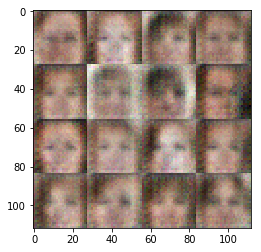

Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.6639... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.6496... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.5167


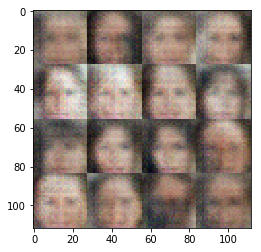

Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.6341


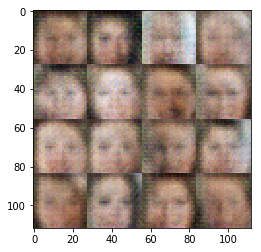

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6532


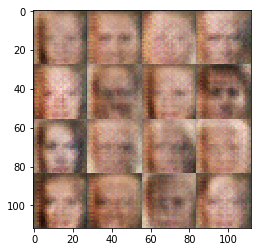

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.6888... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.6140


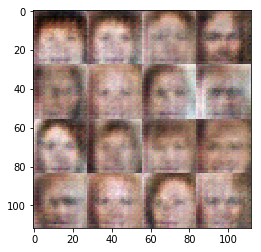

Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6315


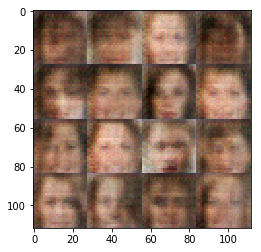

Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7210


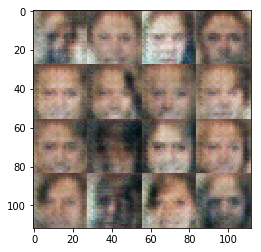

Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6245


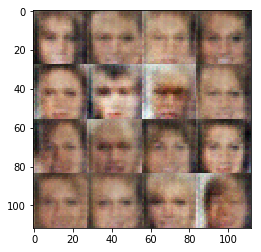

Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.5732


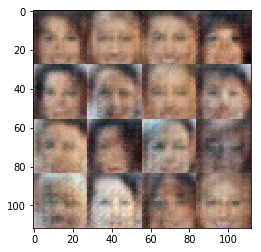

Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6914


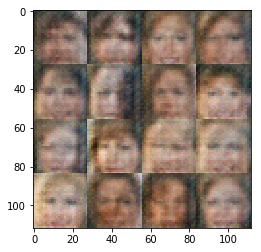

Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7010


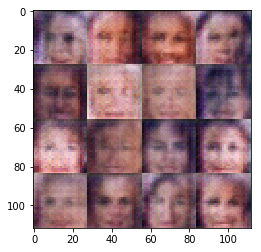

Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.4092
Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6288


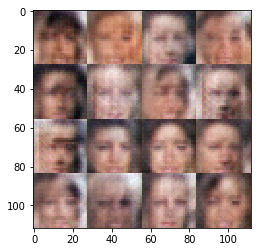

Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.3078
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 3.2066
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.4291


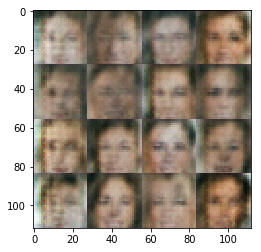

Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 2.2262
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.6006... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 2.2178


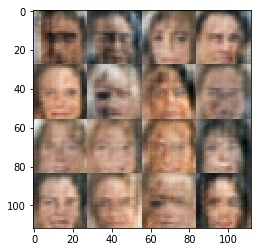

Epoch 1/1... Discriminator Loss: 1.9096... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 2.1854... Generator Loss: 0.1496
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 2.0210


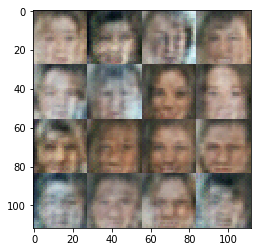

Epoch 1/1... Discriminator Loss: 3.6031... Generator Loss: 2.6647
Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.5597


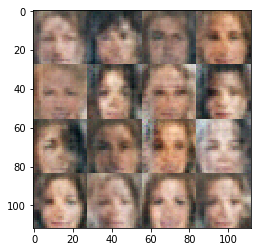

Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.6117... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.6970... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.8090
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.0827


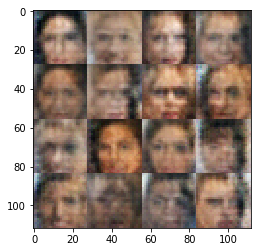

Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.7624... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 3.6392
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.2521... Generator Loss: 3.1614


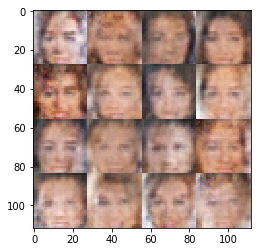

Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 2.3963
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.4882
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 1.6097
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.6736... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9918


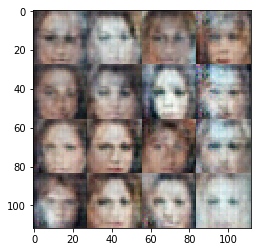

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 2.9204
Epoch 1/1... Discriminator Loss: 1.6887... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 2.5224
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.0118
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 0.8486


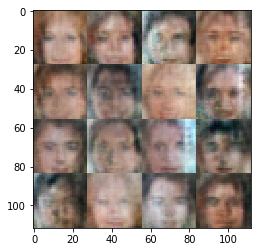

Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.3405
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 1.7546
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 3.3894
Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 3.3768
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 1.5972
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 2.8032
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 2.0873


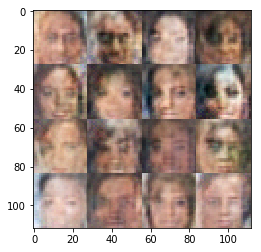

Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.3210
Epoch 1/1... Discriminator Loss: 1.8463... Generator Loss: 0.2063
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 2.3770
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.7276... Generator Loss: 7.8590
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 3.2235
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.4177
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.5423


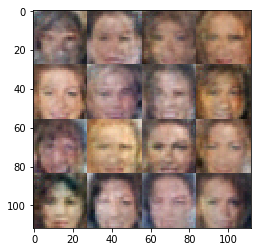

Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.4317
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8092


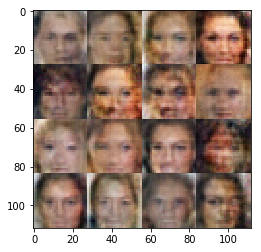

Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 2.0963
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 2.8631... Generator Loss: 0.0850
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.9328
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.8629
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 1.4047


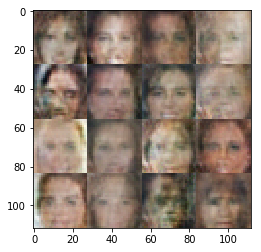

Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 1.9480
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 1.9724... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.0294
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.2948
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 2.3952... Generator Loss: 0.1303


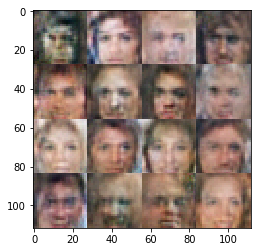

Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 3.3093
Epoch 1/1... Discriminator Loss: 1.8908... Generator Loss: 0.1908
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.7155
Epoch 1/1... Discriminator Loss: 1.7494... Generator Loss: 5.2863
Epoch 1/1... Discriminator Loss: 0.2820... Generator Loss: 2.4261
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 3.1977
Epoch 1/1... Discriminator Loss: 2.2241... Generator Loss: 0.1428
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.7289


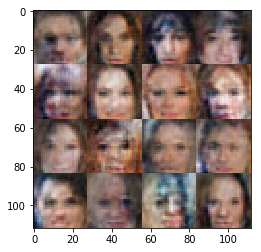

Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.4058
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 3.2122
Epoch 1/1... Discriminator Loss: 2.6295... Generator Loss: 0.0930
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 2.1632
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.3722


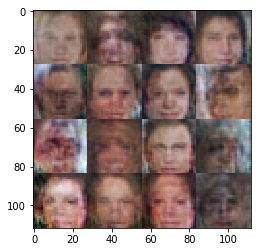

Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 2.1355... Generator Loss: 0.1609
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 2.4096
Epoch 1/1... Discriminator Loss: 2.1769... Generator Loss: 0.1660
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 2.4840
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 2.4974


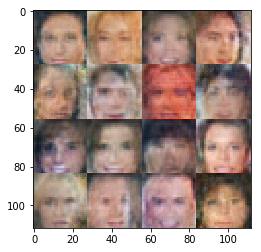

Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.2888
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.5093
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6451


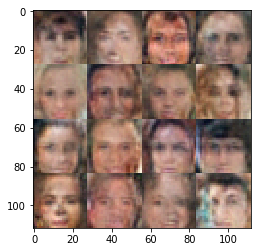

Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.3068
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.9308... Generator Loss: 0.2104
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 2.7640
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 3.4397
Epoch 1/1... Discriminator Loss: 1.8370... Generator Loss: 0.2131


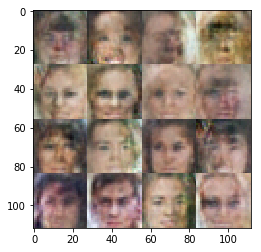

Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.7317... Generator Loss: 0.2424
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.1970
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 2.5558
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.7590... Generator Loss: 0.2611
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.7520... Generator Loss: 0.2522


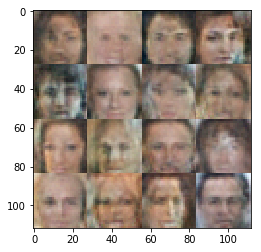

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.2819
Epoch 1/1... Discriminator Loss: 0.3245... Generator Loss: 3.2045
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.3723
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 2.1264... Generator Loss: 0.1672


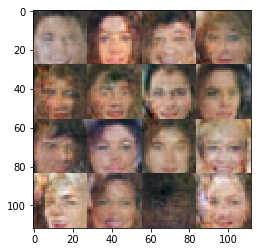

Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.6957... Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 2.3114... Generator Loss: 0.1343
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.3622


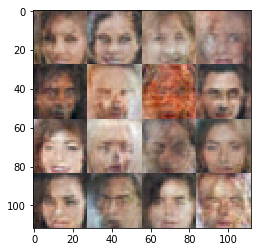

Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.2820
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 1.8422... Generator Loss: 0.2393
Epoch 1/1... Discriminator Loss: 1.7123... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4359


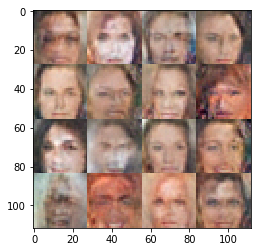

Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 2.2194... Generator Loss: 0.1444
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 2.7340
Epoch 1/1... Discriminator Loss: 1.8682... Generator Loss: 0.2527
Epoch 1/1... Discriminator Loss: 2.3382... Generator Loss: 0.1424
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.8907


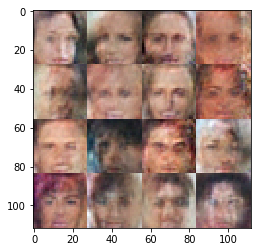

Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.8664... Generator Loss: 0.2349
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 2.0095
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 3.7951


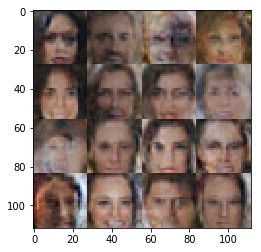

Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.3825
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 1.7339... Generator Loss: 0.2820
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.8689... Generator Loss: 0.2292


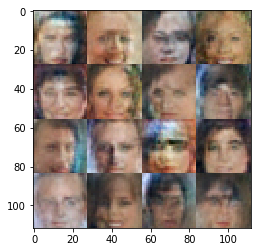

Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.2863
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.3246
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.8233... Generator Loss: 0.2631
Epoch 1/1... Discriminator Loss: 2.0882... Generator Loss: 0.1941


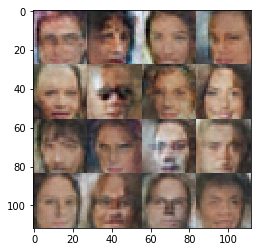

Epoch 1/1... Discriminator Loss: 1.9133... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 1.7011... Generator Loss: 0.2976
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 2.0962... Generator Loss: 0.1649
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.7658... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7759


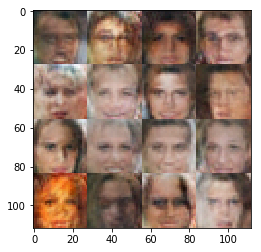

Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.3894
Epoch 1/1... Discriminator Loss: 2.0797... Generator Loss: 0.1716
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.4503


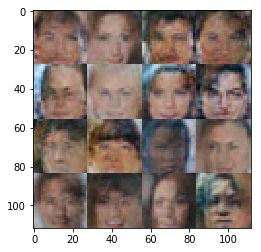

Epoch 1/1... Discriminator Loss: 2.0177... Generator Loss: 0.1917
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 1.3496
Epoch 1/1... Discriminator Loss: 2.6354... Generator Loss: 0.0893
Epoch 1/1... Discriminator Loss: 1.7354... Generator Loss: 0.3329
Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.3586
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.4278


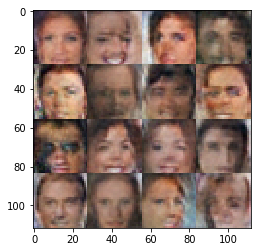

Epoch 1/1... Discriminator Loss: 1.8539... Generator Loss: 0.2309
Epoch 1/1... Discriminator Loss: 2.3233... Generator Loss: 0.1574
Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 0.2240
Epoch 1/1... Discriminator Loss: 1.8918... Generator Loss: 0.2241
Epoch 1/1... Discriminator Loss: 1.9320... Generator Loss: 0.2056
Epoch 1/1... Discriminator Loss: 2.5420... Generator Loss: 0.1095
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 2.1172... Generator Loss: 0.1679
Epoch 1/1... Discriminator Loss: 2.2071... Generator Loss: 0.1442


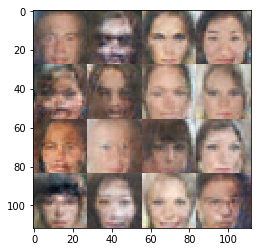

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.3990
Epoch 1/1... Discriminator Loss: 2.1422... Generator Loss: 0.1784
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.8837... Generator Loss: 0.2167
Epoch 1/1... Discriminator Loss: 2.1949... Generator Loss: 0.1498
Epoch 1/1... Discriminator Loss: 2.7277... Generator Loss: 0.1663
Epoch 1/1... Discriminator Loss: 2.1055... Generator Loss: 0.2200


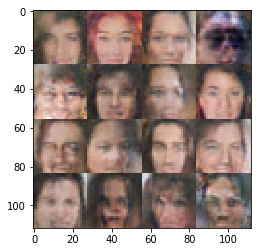

Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 2.0684... Generator Loss: 0.2009
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.8448... Generator Loss: 0.3123
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 2.3959... Generator Loss: 0.1254
Epoch 1/1... Discriminator Loss: 2.1007... Generator Loss: 0.4037


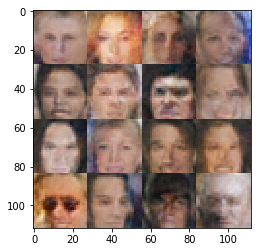

Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.5423
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 1.8518... Generator Loss: 0.2485
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.4384


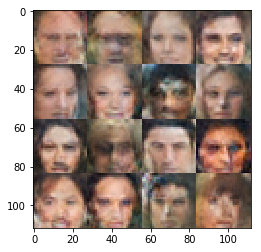

Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.9238
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 2.4002... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 2.0178... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.3157
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.4468


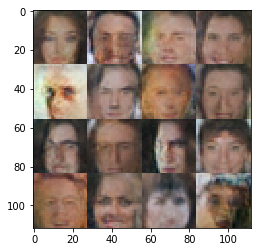

Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.2997
Epoch 1/1... Discriminator Loss: 1.9652... Generator Loss: 0.2196
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 2.0079... Generator Loss: 0.2126
Epoch 1/1... Discriminator Loss: 1.8167... Generator Loss: 0.2330
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 2.1078... Generator Loss: 0.2046
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.6499... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.8150


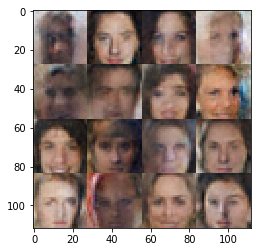

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.7879... Generator Loss: 0.2352
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 2.0831... Generator Loss: 0.1787
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.2884
Epoch 1/1... Discriminator Loss: 1.9760... Generator Loss: 0.2232
Epoch 1/1... Discriminator Loss: 1.8112... Generator Loss: 0.2254


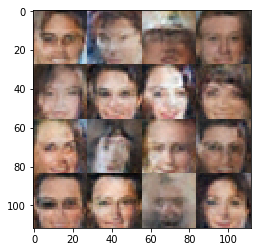

Epoch 1/1... Discriminator Loss: 1.7231... Generator Loss: 0.2783
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 2.2776... Generator Loss: 0.1448
Epoch 1/1... Discriminator Loss: 1.6838... Generator Loss: 0.2962
Epoch 1/1... Discriminator Loss: 2.3084... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.7459... Generator Loss: 0.2710
Epoch 1/1... Discriminator Loss: 1.8273... Generator Loss: 0.2479
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.8023


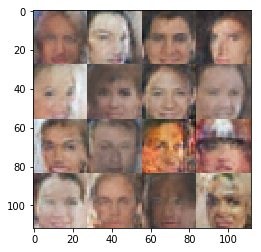

Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.3752
Epoch 1/1... Discriminator Loss: 2.4699... Generator Loss: 0.1550
Epoch 1/1... Discriminator Loss: 1.7154... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 1.9148... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.9294... Generator Loss: 0.2950
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.3287


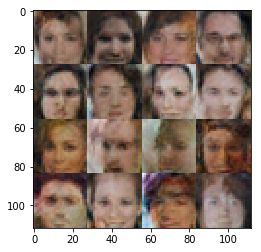

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.8034... Generator Loss: 0.2847
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 2.0594... Generator Loss: 0.1840
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.7159... Generator Loss: 0.2637
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 0.3187
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.3582


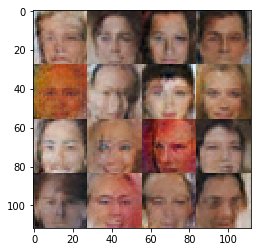

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 2.0373... Generator Loss: 0.2177
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 2.1588... Generator Loss: 0.1600
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.3658
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.3481
Epoch 1/1... Discriminator Loss: 2.1871... Generator Loss: 0.1587
Epoch 1/1... Discriminator Loss: 1.7460... Generator Loss: 0.3707


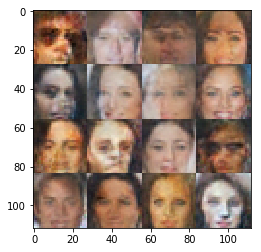

Epoch 1/1... Discriminator Loss: 1.8604... Generator Loss: 0.2206
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 2.3200... Generator Loss: 0.1390
Epoch 1/1... Discriminator Loss: 2.0839... Generator Loss: 0.1902
Epoch 1/1... Discriminator Loss: 1.9714... Generator Loss: 0.2415
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.9764... Generator Loss: 0.2261


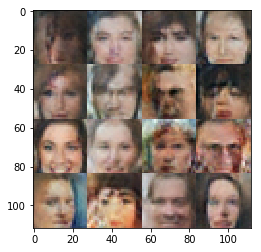

Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.9237... Generator Loss: 0.2616
Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 0.2144
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 2.5313... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 2.3181... Generator Loss: 0.1483
Epoch 1/1... Discriminator Loss: 1.8578... Generator Loss: 0.2443
Epoch 1/1... Discriminator Loss: 2.0021... Generator Loss: 0.1754
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5553


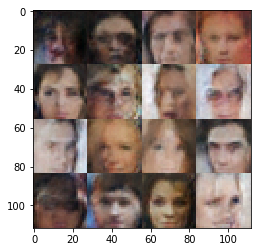

Epoch 1/1... Discriminator Loss: 1.5955... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 2.4505... Generator Loss: 0.1043
Epoch 1/1... Discriminator Loss: 2.1815... Generator Loss: 0.2403
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 2.4028... Generator Loss: 0.1291
Epoch 1/1... Discriminator Loss: 2.0076... Generator Loss: 0.1955
Epoch 1/1... Discriminator Loss: 1.7858... Generator Loss: 0.2493
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.3983


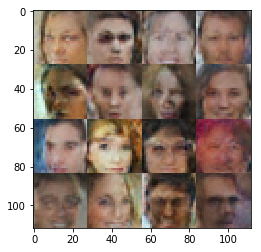

Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.8429
Epoch 1/1... Discriminator Loss: 2.3568... Generator Loss: 0.1460
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.3619
Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 0.2959
Epoch 1/1... Discriminator Loss: 2.0263... Generator Loss: 0.2154
Epoch 1/1... Discriminator Loss: 1.7596... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 2.0589... Generator Loss: 0.1659
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 2.0091... Generator Loss: 0.1822


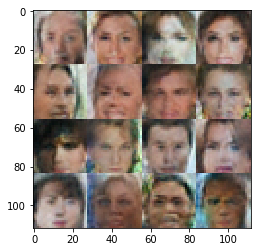

Epoch 1/1... Discriminator Loss: 1.8439... Generator Loss: 0.2298
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 2.6645... Generator Loss: 0.1270
Epoch 1/1... Discriminator Loss: 1.7224... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 2.4441... Generator Loss: 0.1265
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 0.1865
Epoch 1/1... Discriminator Loss: 2.3581... Generator Loss: 0.1647


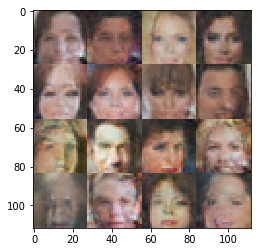

Epoch 1/1... Discriminator Loss: 2.2531... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 2.2933... Generator Loss: 0.1818
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 2.3852... Generator Loss: 0.1258
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.9479... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 2.4332... Generator Loss: 0.1114
Epoch 1/1... Discriminator Loss: 2.7750... Generator Loss: 0.0932


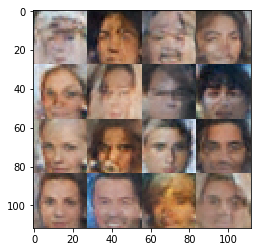

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 2.1064... Generator Loss: 0.1910
Epoch 1/1... Discriminator Loss: 2.1722... Generator Loss: 0.1978
Epoch 1/1... Discriminator Loss: 2.0577... Generator Loss: 0.2568
Epoch 1/1... Discriminator Loss: 1.9848... Generator Loss: 0.1916
Epoch 1/1... Discriminator Loss: 2.0946... Generator Loss: 0.1676
Epoch 1/1... Discriminator Loss: 1.9755... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.2917


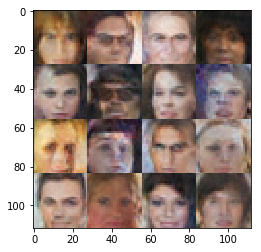

Epoch 1/1... Discriminator Loss: 2.0965... Generator Loss: 0.1860
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.9941... Generator Loss: 0.2046
Epoch 1/1... Discriminator Loss: 2.1192... Generator Loss: 0.1767
Epoch 1/1... Discriminator Loss: 2.0941... Generator Loss: 0.2005
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.7642... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 2.3870... Generator Loss: 0.1409
Epoch 1/1... Discriminator Loss: 1.9791... Generator Loss: 0.2215


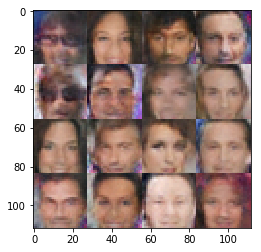

Epoch 1/1... Discriminator Loss: 2.0612... Generator Loss: 0.1970
Epoch 1/1... Discriminator Loss: 2.1077... Generator Loss: 0.2052
Epoch 1/1... Discriminator Loss: 2.1149... Generator Loss: 0.1579
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.9020... Generator Loss: 0.2585
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.3198
Epoch 1/1... Discriminator Loss: 1.9879... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 2.3248... Generator Loss: 0.1596


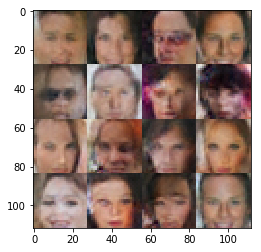

Epoch 1/1... Discriminator Loss: 2.0712... Generator Loss: 0.1904
Epoch 1/1... Discriminator Loss: 2.2375... Generator Loss: 0.1452
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.4828


In [18]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.